# EXAMEN 2

Cada error u omisión en un ejercicio resta 0.5 puntos.

Cada código demás (que no se ha pedido) se interpretará como que no se está seguro de lo que se pide y resta 0.25 puntos.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image
from io import BytesIO

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split


2025-02-17 18:38:22.672451: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-17 18:38:22.680569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-17 18:38:22.691717: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-17 18:38:22.694642: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-17 18:38:22.702268: I tensorflow/core/platform/cpu_feature_guar

## EJERCICIO 1

El conjunto de datos cats_vs_dogs https://www.tensorflow.org/datasets/catalog/cats_vs_dogs?hl=es-419 es un conjunto de imágenes de perros y gatos.

Tienes que entrenar un modelo de redes convolucionales para que aprenda a clasificar entre perro y gato, pero no vamos a empezar de cero, vamos a usar alguna de las redes ya existentes: InceptionV3.

Tienes que seguir los siguientes pasos:
* Carga el conjunto de imágenes (entrenamiento, validación y pruebas)
* Explora los datos: número de elementos, número de clases, nombres de las clases y dibuja algunas imágenes con sus etiquetas...
* Prepara los datos: añade más elementos al conjunto de entrenamiento (rotando, trasladando... las imágenes actuales) y prepara los datos para el modelo.
* Entrena un modelo para estos datos usando InceptionV3 y muestra todas las capas del modelo.
* Busca una imagen en Internet y haz una predicción.

Puedes usar take(10) a la hora de entrenar aunque los resultados sean malísimos, con el fin de que no pierdas tiempo. Usa pocos epoch y añade como comentarios que valores pondrías realmente.

In [39]:
# Ruta al directorio de imágenes
data_dir = "/home/iabd/tensorflow_datasets/cats_vs_dogs/PetImages"

# Cargar los datos 
train_dataset = image_dataset_from_directory(
   data_dir,
   validation_split=0.2,
   subset="training",
   seed=42,
   image_size=(150, 150),
   batch_size=32
)


validation_dataset = image_dataset_from_directory(
   data_dir,
   validation_split=0.2,
   subset="validation",
   seed=42,
   image_size=(150, 150),
   batch_size=32
)


class_names = train_dataset.class_names
print(f"Nombres de las clases: {class_names}")

num_train = len(train_dataset) * 32
num_val = len(validation_dataset) * 32
print(f"Imágenes en entrenamiento: {num_train}")
print(f"Imágenes en validación: {num_val}")

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Nombres de las clases: ['Cat', 'Dog']
Imágenes en entrenamiento: 20000
Imágenes en validación: 5024


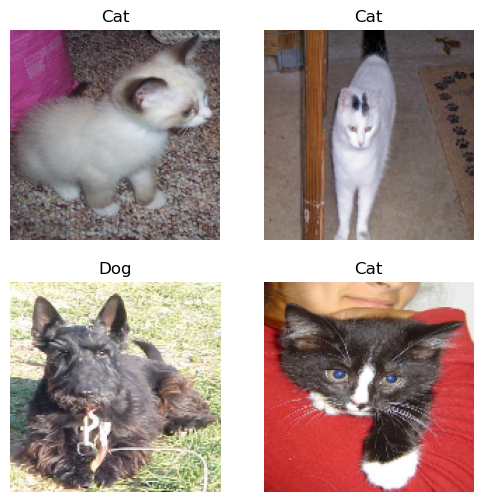

In [40]:
def plot_images(images, labels):
    plt.figure(figsize=(6, 6))  
    for i in range(4):  
        plt.subplot(2, 2, i+1)  
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.show()

images, labels = next(iter(train_dataset))
plot_images(images, labels)


In [ ]:
data_augmentation = tf.keras.Sequential([
   layers.RandomRotation(0.2),
   layers.RandomFlip("horizontal"), 
   layers.RandomZoom(0.2)
])

def preprocess(image, label):
   image = tf.cast(image, tf.float32) / 255.0
   return image, label

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
train_dataset = train_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)

train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

base_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Congelar las capas del modelo 

# Crear el modelo
model = models.Sequential([
   base_model,
   layers.GlobalAveragePooling2D(),
   layers.Dense(128, activation='relu'),
   layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Mostrar todas las capas del modelo
model.summary()

# Entrenar el modelo
epocas = 5  # Si queremos probar el código rápidamente usamos solo 5 épocas, usar 20-30 épocas para entrenar el modelo completamente
history = model.fit(
   train_dataset.take(10),  # Usamos solo 10 lotes para probar el código rápidamente, usar train_dataset para entrenar el modelo completamente
   epochs=epocas,
   validation_data=validation_dataset.take(10) # Usariamos todos los datos como lo hemos mencionado anteriormente
)

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,065,185 (84.17 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 265ms/step - accuracy: 0.5762 - loss: 2.3229 - val_accuracy: 0.9281 - val_loss: 0.1970
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.8309 - loss: 0.3212 - val_accuracy: 0.9312 - val_loss: 0.2036
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.8799 - loss: 0.3013 - val_accuracy: 0.9656 - val_loss: 0.0950
Epoch 4/5
 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9219 - loss: 0.1584 

Corrupt JPEG data: 164 extraneous bytes before marker 0xd9


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.8995 - loss: 0.2028 - val_accuracy: 0.9469 - val_loss: 0.1250
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.9400 - loss: 0.1677 - val_accuracy: 0.9531 - val_loss: 0.1025


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


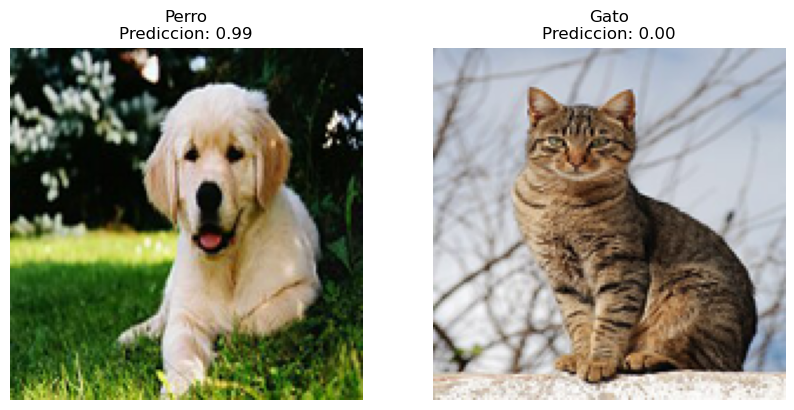

In [42]:
urls = [
   "https://upload.wikimedia.org/wikipedia/commons/thumb/8/86/Golden_Retriever_10weeks.jpg/220px-Golden_Retriever_10weeks.jpg", 
   "https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Cat_November_2010-1a.jpg/220px-Cat_November_2010-1a.jpg"  
]

img_arrays = []
original_images = []
for url in urls:
   response = requests.get(url)
   img = Image.open(BytesIO(response.content))
   img = img.resize((150, 150))
   original_images.append(img)
   img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
   img_arrays.append(img_array)

img_arrays = np.array(img_arrays)
predictions = model.predict(img_arrays)

# Mostrar resultados
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, prediction in enumerate(predictions):
   clase = "Perro" if prediction[0] > 0.5 else "Gato"
   axes[i].imshow(original_images[i])
   axes[i].axis('off')
   axes[i].set_title(f"{clase}\nPrediccion: {prediction[0]:.2f}")
plt.show()


## EJERCICIO 2

Tienes que detectar cuantos coches cruzan la línea. Tienes el video origen (trafico.mp4) así como el video de como quiero que quede (trafico_resultado.mp4), fíjate las etiquetas de los objetos y donde está la línea para contar los objetos.

Tienes que guardar en un archivo .mp4 el video que se crear y tienes que escribir en la terminal el marcador final.

## EJERCICIO 3
A partir de los datos proporcionados:
* Crea dos conjuntos de datos: train y test
* Crea el modelo que tienes en la imagen modelo.png
* Muestra en una imagen el modelo creado.
* Entrena el modelo probando diferentes tasas de aprendizaje usando detención temprana y evalúa cada modelo en el conjunto de test (en el entrenamiento indica que tiene que coger el 5% para el conjunto de validación).
* Guarda el modelo cuya media de las métricas de las tres salidas en el conjunto de test sea la mejor.
* Indica cuál es la tasa de aprendizaje del modelo elegido.

In [31]:
# Generar datos artificiales
np.random.seed(42)
X = np.random.rand(5000, 15) * 15  # 5000 muestras con 15 características entre 0 y 15
X1 = X[:, :10]  # Primera entrada con 10 características
X2 = X[:, 5:15]  # Segunda entrada con 10 características solapadas

# Agregar ruido aleatorio a Y
noise = np.random.normal(0, 0.1, (5000, 3))
Y1 = np.sin(np.sum(X1, axis=1)) + np.cos(np.sum(X2, axis=1)) + noise[:, 0]
Y2 = np.tanh(np.prod(X1, axis=1) * np.prod(X2, axis=1)) + noise[:, 1]
Y3 = np.log1p(np.mean(X1, axis=1) + np.mean(X2, axis=1)) + noise[:, 2]

# Concatenar las salidas en una matriz de etiquetas Y
Y = np.column_stack((Y1, Y2, Y3))

# Dividir los datos en conjuntos de entrenamiento (80%) y prueba (20%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Función para construir el modelo
def build_model():
    # Definir entradas
    input1 = keras.Input(shape=(10,))
    input2 = keras.Input(shape=(10,))

    # Normalización de las entradas
    normalization_layer_1 = layers.Normalization()
    normalization_layer_1.adapt(X_train[:, :10])  # Ajustar con las primeras 10 características

    normalization_layer_2 = layers.Normalization()
    normalization_layer_2.adapt(X_train[:, 5:15])  # Ajustar con las últimas 10 características

    # Rama 1
    x1 = normalization_layer_1(input1)
    x1 = layers.Dense(200, activation="relu")(x1)
    x1 = layers.Dense(200, activation="relu")(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Dense(100, activation="relu")(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Dense(100, activation="relu")(x1)

    # Rama 2
    x2 = normalization_layer_2(input2)

    # Rama 2 izquierda
    x2_1 = layers.Dense(100, activation="relu")(x2)
    x2_1_salida = layers.Dense(100, activation="relu")(x2_1)

    # Rama 2 derecha
    x2_2 = layers.Dense(100, activation="relu")(x2)
    x2_2 = layers.Dense(100, activation="relu")(x2_2)
    x2_2 = layers.Dense(100, activation="relu")(x2_2)
    x2_2 = layers.Dropout(0.5)(x2_2)

    # Concatenar rama 1 y rama 2 izquierda
    conca12izq = layers.Concatenate()([x1, x2_1_salida])

    # Concatenar rama 2 derecha con rama 2 izquierda
    conca12 = layers.Concatenate()([x2_1_salida, x2_2])

    # Salidas
    out1 = layers.Dense(1)(conca12izq)
    out2 = layers.Dense(1)(conca12)
    out3 = layers.Dense(1)(x2_1_salida)

    # Definir modelo
    return keras.Model(inputs=[input1, input2], outputs=[out1, out2, out3])

# Búsqueda de la mejor tasa de aprendizaje
learning_rates = [0.01, 0.001, 0.0001]
best_model = None
best_score = float("inf")
best_lr = None

for lr in learning_rates:
    print(f"Entrenando con tasa de aprendizaje: {lr}")
    
    # Construir el modelo
    current_model = build_model()
    
    # Compilar el modelo
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    current_model.compile(optimizer=optimizer, loss="mse")
    
    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Entrenar el modelo
    history = current_model.fit(
        [X_train[:, :10], X_train[:, 5:15]], 
        [Y_train[:, 0], Y_train[:, 1], Y_train[:, 2]],  
        validation_split=0.05,
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Evaluar el modelo
    test_loss = current_model.evaluate(
        [X_test[:, :10], X_test[:, 5:15]], 
        [Y_test[:, 0], Y_test[:, 1], Y_test[:, 2]], 
        verbose=0
    )
    
    # Mostrar resultados
    print(f"Tasa de aprendizaje: {lr}, Pérdida en test: {test_loss}")
    
    # Actualizar el mejor modelo
    if np.mean(test_loss) < best_score:
        best_score = np.mean(test_loss)
        best_model = current_model
        best_lr = lr

# Guardar el mejor modelo
if best_model:
    best_model.save("best_model.keras")
    print(f"Mejor modelo guardado como 'best_model.keras' con tasa de aprendizaje: {best_lr}")

Entrenando con tasa de aprendizaje: 0.01
Epoch 1/100


2025-02-17 18:59:05.268884: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1804', 20 bytes spill stores, 20 bytes spill loads

2025-02-17 18:59:05.298033: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1804', 12 bytes spill stores, 12 bytes spill loads

2025-02-17 18:59:05.305915: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1804', 8 bytes spill stores, 8 bytes spill loads

2025-02-17 18:59:05.311214: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1895', 8 bytes spill stores, 8 bytes spill loads



108/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - dense_31_loss: 1.3394 - dense_32_loss: 0.1295 - dense_33_loss: 0.8125 - loss: 2.2813

2025-02-17 18:59:07.647215: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1804', 8 bytes spill stores, 8 bytes spill loads

2025-02-17 18:59:08.115602: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1895', 24 bytes spill stores, 24 bytes spill loads

2025-02-17 18:59:08.156667: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1804', 20 bytes spill stores, 20 bytes spill loads

2025-02-17 18:59:08.256569: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1804', 12 bytes spill stores, 12 bytes spill loads



119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - dense_31_loss: 1.3232 - dense_32_loss: 0.1224 - dense_33_loss: 0.7601 - loss: 2.2057 - val_dense_31_loss: 1.0719 - val_dense_32_loss: 0.0205 - val_dense_33_loss: 0.0596 - val_loss: 1.2004
Epoch 2/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - dense_31_loss: 1.0396 - dense_32_loss: 0.0158 - dense_33_loss: 0.0515 - loss: 1.1070 - val_dense_31_loss: 1.0519 - val_dense_32_loss: 0.0131 - val_dense_33_loss: 0.0221 - val_loss: 1.1117
Epoch 3/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - dense_31_loss: 1.0465 - dense_32_loss: 0.0122 - dense_33_loss: 0.0237 - loss: 1.0824 - val_dense_31_loss: 1.0278 - val_dense_32_loss: 0.0120 - val_dense_33_loss: 0.0213 - val_loss: 1.0987
Epoch 4/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - dense_31_loss: 1.0415 - dense_32_loss: 0.0117 - dense_33_loss: 0.0269 - loss: 1.0802 - val_dense_31_loss: 1.0657 - val_dense_32_loss: 0.0129 - val_dense_33_loss: 0.0254 - val_loss: 1.1507
Epoch 5/100
119/119 ━━━━━━━━━━━━━━━━━━━

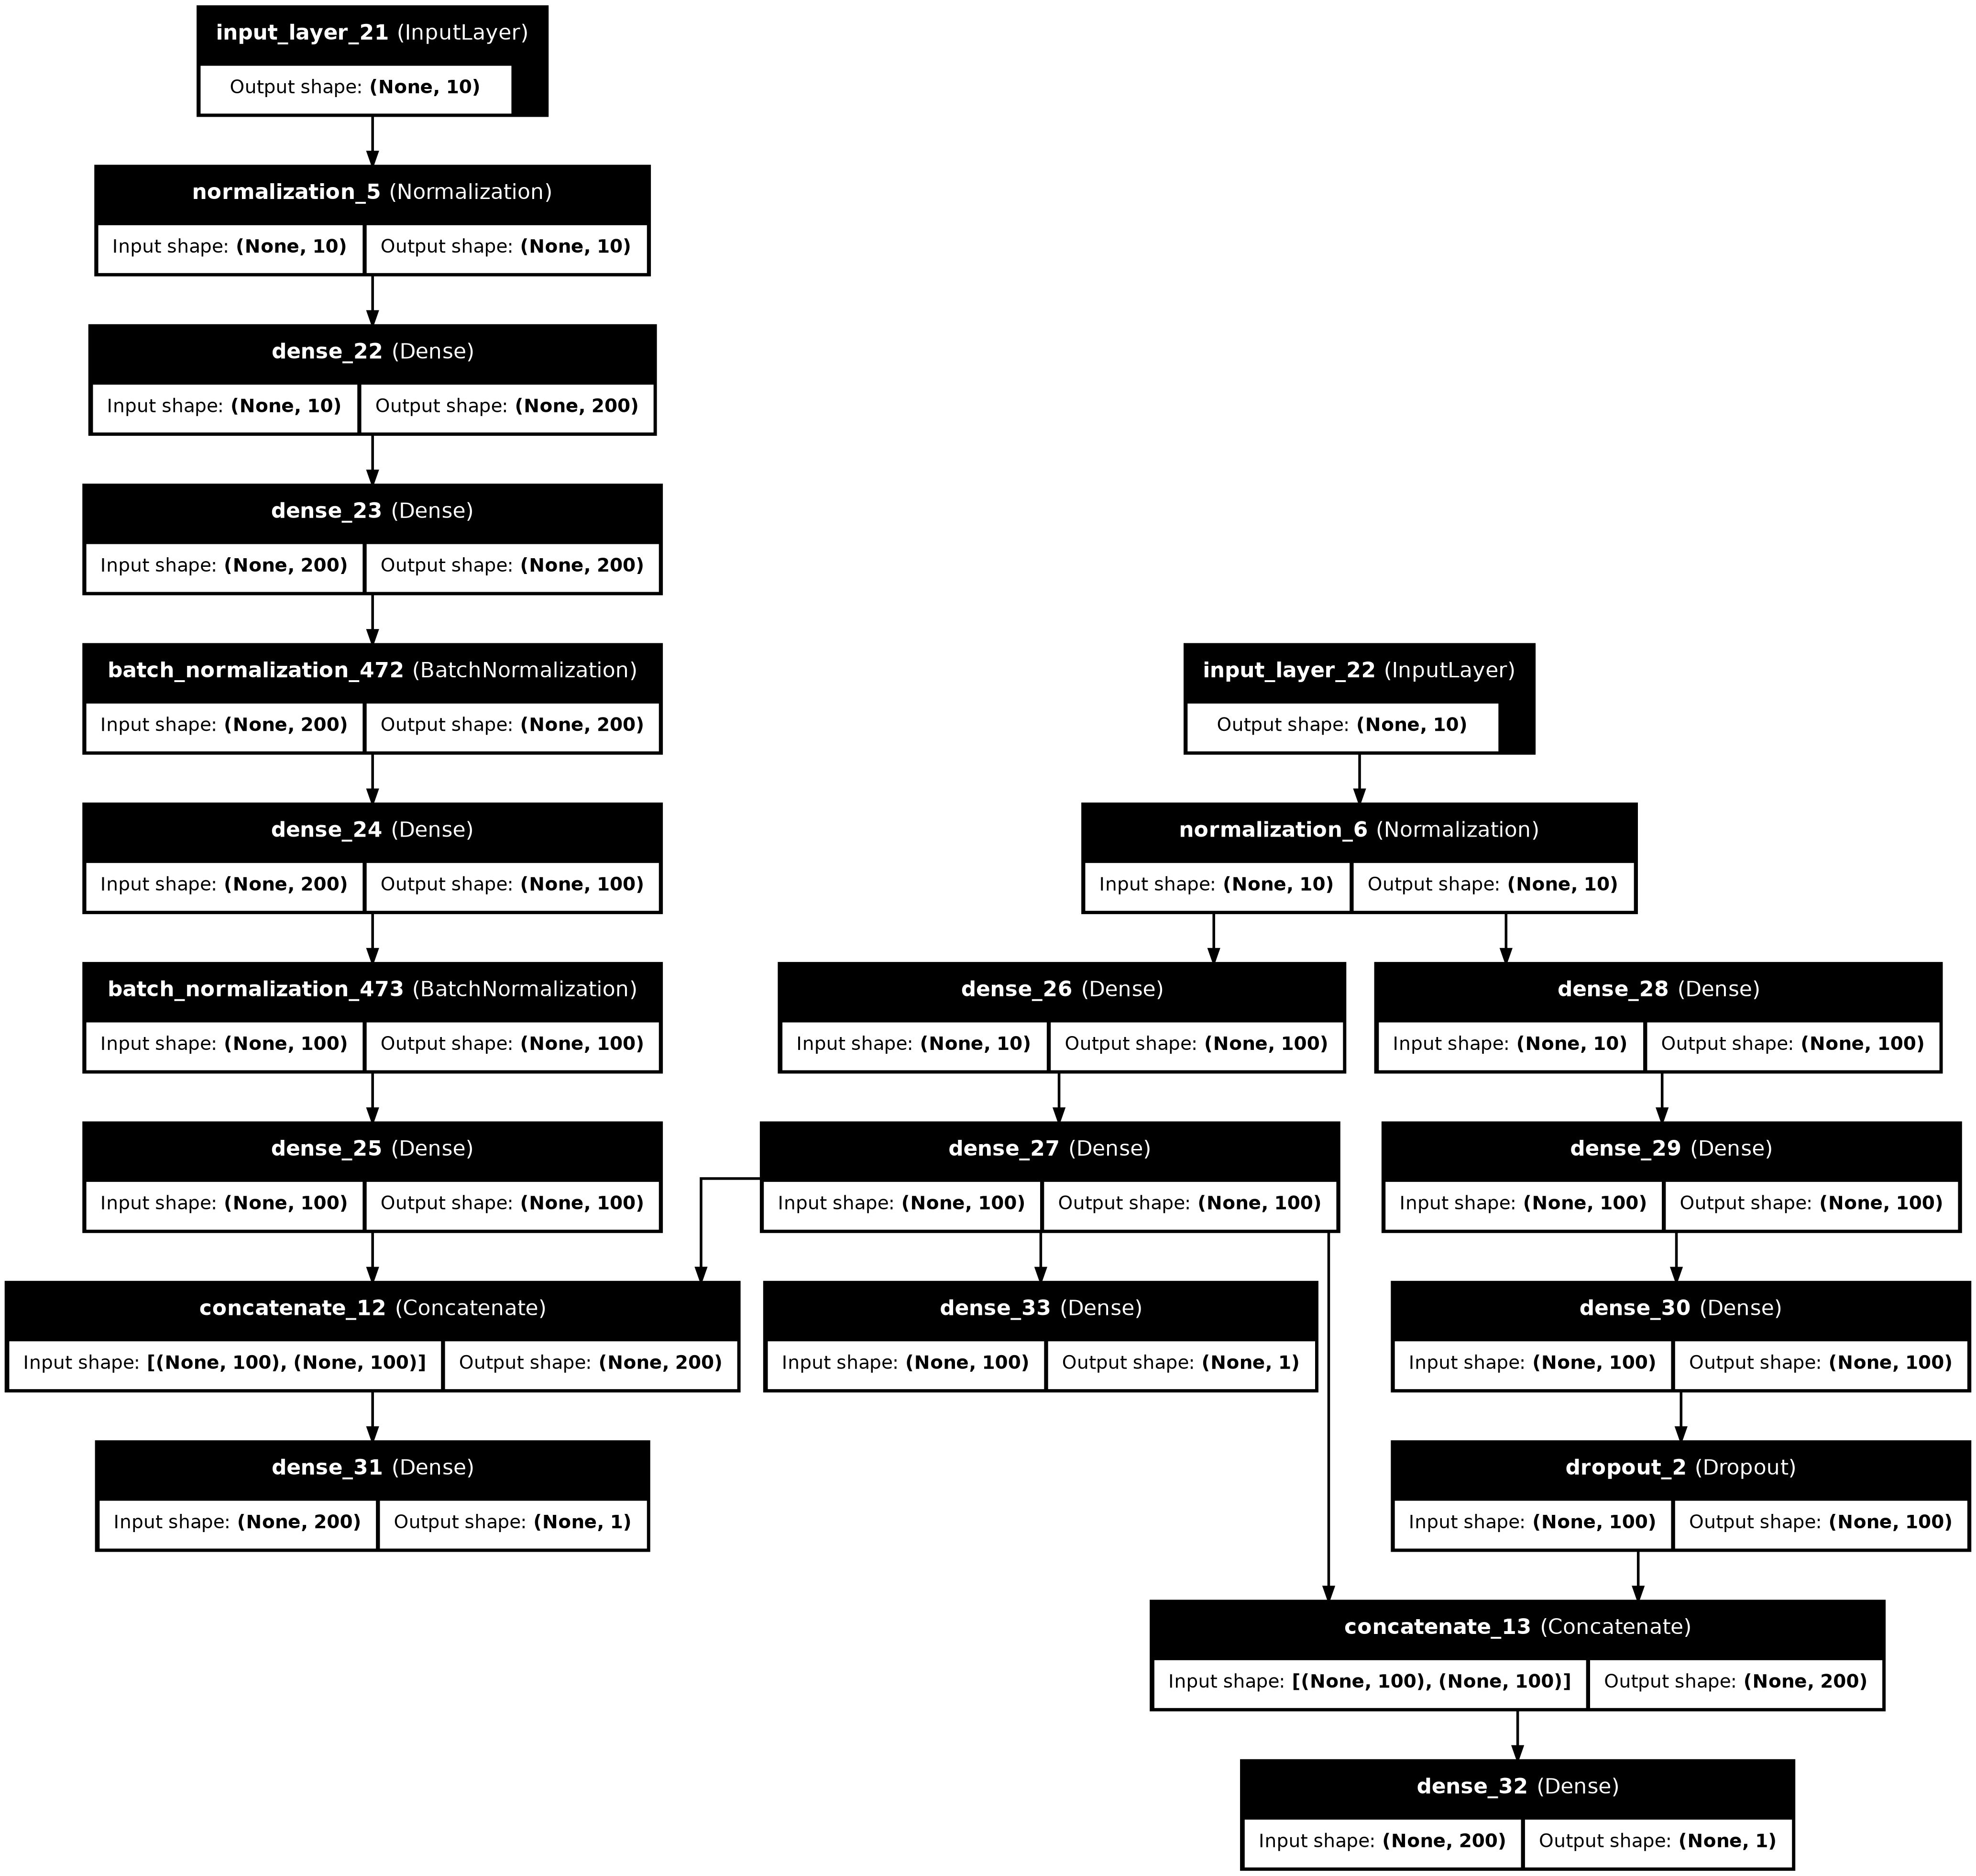

In [32]:
from tensorflow.keras.utils import plot_model

# Generar la imagen del modelo
plot_model(best_model, to_file='modelo.png', show_shapes=True, show_layer_names=True)